In [1]:
!pip install -q timm einops wikipedia chromadb open_clip_torch


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
google-cloud-pubsublite 1.8.3 requires overrides<7.0.0,>=6.0.1, but you have overrides 7.4.0 which is incompatible.
jupyterlab 4.0.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.1 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.1 requires jupyterlab<5.0.0a0,>=4.0.6, but you have jupyterlab 4.0.5 which is incompatible.
kfp 2.0.1 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.0.1 requires kubernetes<27,>=8.0.0, but you have kubernetes 28.1.0 which 

In [2]:
!pip install -q transformers==4.36.0
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

In [3]:
import wikipedia
from tqdm import tqdm
import shutil

import os


images_pth = '/kaggle/input/flowers/flowers'
imges_classes = os.listdir(images_pth)

new_pth = 'flowers'
if not os.path.exists(new_pth):
    os.mkdir(new_pth)


for cls in tqdm(imges_classes):
    cls_pth = os.path.join(images_pth, cls)
    new_cls_pth = os.path.join(new_pth, cls)
    if not os.path.exists(new_cls_pth):
        os.mkdir(new_cls_pth)
    for img in os.listdir(cls_pth)[:10]:
        img_pth = os.path.join(cls_pth, img)
        new_img_pth = os.path.join(new_cls_pth, img)
        shutil.copy(img_pth, new_img_pth)
        


100%|██████████| 7/7 [00:01<00:00,  3.75it/s]


In [4]:
imges_classes

['bellflower', 'dandelion', 'daisy', 'sunflower', 'tulip', 'lotus', 'rose']

In [5]:
# secondly we will get text from wiki and save it in txt file            
wiki_titles = { # the key is imgs class and the value is wiki title
    'daisy': 'Bellis perennis',
    'dandelion': 'Taraxacum',
    'lotus': 'Nelumbo nucifera',
    'rose': 'Rose',
    'sunflower': 'Common sunflower',
    'tulip': 'Tulip',
    'bellflower':'Campanula'
}

In [6]:
# each class has 10 images and one text file content from the wiki page
for cls in tqdm(imges_classes):
    cls_pth = os.path.join(new_pth, cls)
#     page_content = wikipedia.page(wiki_titles[cls], auto_suggest=False).content
    page_content = wikipedia.summary(wiki_titles[cls] ,auto_suggest=False)

    if not os.path.exists(cls_pth):
        print('Creating {} folder'.format(cls))
    else:
        #save the text file
        files_name= cls+'.txt'
        with open(os.path.join(cls_pth, files_name), 'w') as f:
            f.write(page_content)

100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


In [7]:
!mkdir all_data # this folder will contain the in very messy way
! cp -r /kaggle/working/flowers/*/* /kaggle/working/all_data

# Vector DB

In [8]:
import chromadb

from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader
from chromadb.config import Settings


client = chromadb.PersistentClient(path="DB")

embedding_function = OpenCLIPEmbeddingFunction()
image_loader = ImageLoader()

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [9]:
collection_images = client.create_collection(
    name='multimodal_collection_images', 
    embedding_function=embedding_function, 
    data_loader=image_loader)

collection_text = client.create_collection(
    name='multimodal_collection_text', 
    embedding_function=embedding_function, 
    )

In [10]:
# Get the uris to the images
IMAGE_FOLDER = '/kaggle/working/all_data'


image_uris = sorted([os.path.join(IMAGE_FOLDER, image_name) for image_name in os.listdir(IMAGE_FOLDER) if not image_name.endswith('.txt')])
ids = [str(i) for i in range(len(image_uris))]

collection_images.add(ids=ids, uris=image_uris)

In [11]:
# let's test and play with our VEC-DB

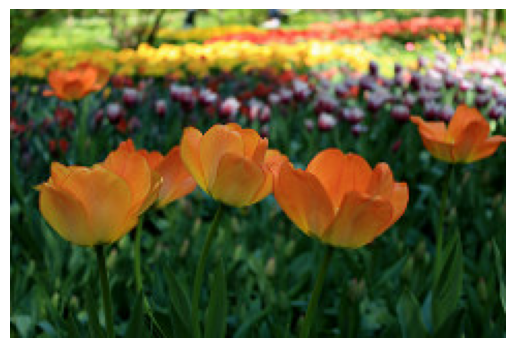

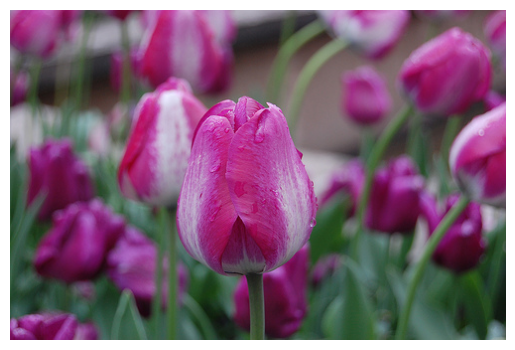

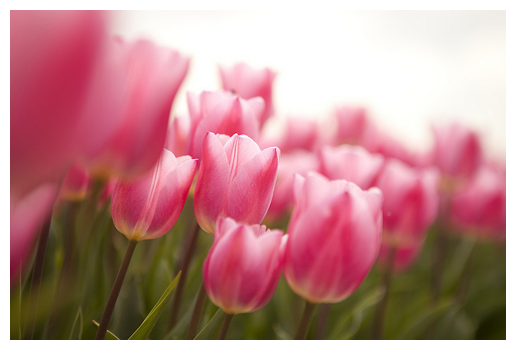

In [12]:
from matplotlib import pyplot as plt

retrieved = collection_images.query(query_texts=["tulip"], include=['data'], n_results=3)
for img in retrieved['data'][0]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

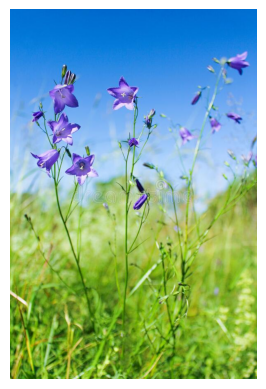

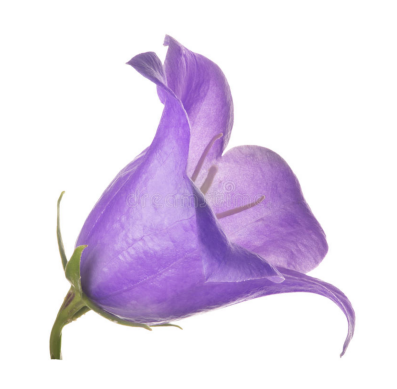

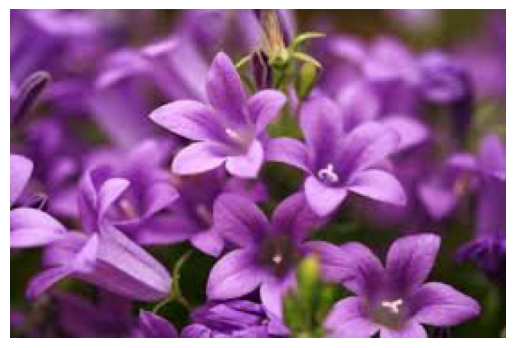

In [13]:
from matplotlib import pyplot as plt

retrieved = collection_images.query(query_texts=["bellflower"], include=['data'], n_results=3)
for img in retrieved['data'][0]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Query Image


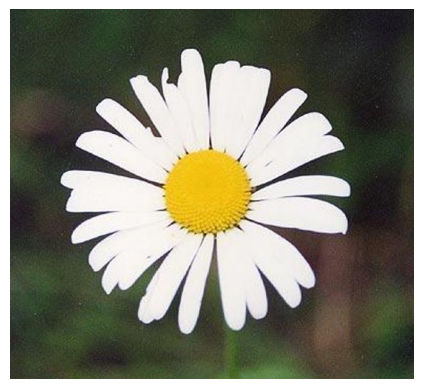

Results


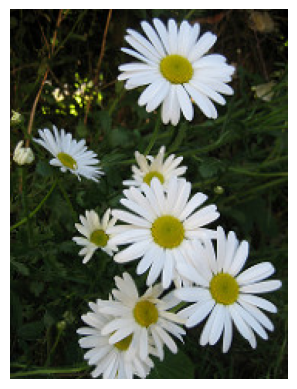

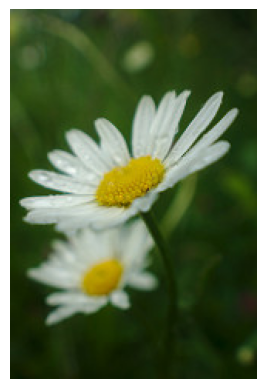

In [14]:
from PIL import Image
import numpy as np

query_image = np.array(Image.open(f"/kaggle/input/flowers/flowers/daisy/0.jpg"))
print("Query Image")
plt.imshow(query_image)
plt.axis('off')
plt.show()

print("Results")
retrieved = collection_images.query(query_images=[query_image], include=['data'], n_results=3)
for img in retrieved['data'][0][1:]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Query Image


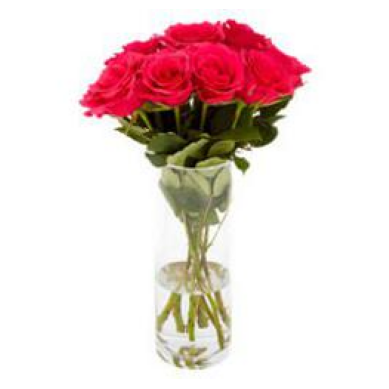

Results


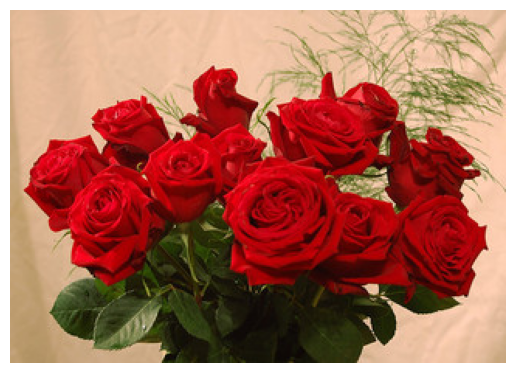

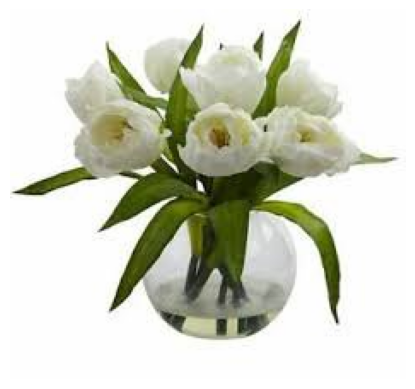

In [15]:
from PIL import Image
import numpy as np

query_image = np.array(Image.open(f"/kaggle/input/flowers/flowers/rose/0444a369fb.jpg"))
print("Query Image")
plt.imshow(query_image)
plt.axis('off')
plt.show()

print("Results")
retrieved = collection_images.query(query_images=[query_image], include=['data'], n_results=3)
for img in retrieved['data'][0][1:]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [16]:
# now the text DB
from chromadb.utils import embedding_functions
default_ef = embedding_functions.DefaultEmbeddingFunction()

text_pth = sorted([os.path.join(IMAGE_FOLDER, image_name) for image_name in os.listdir(IMAGE_FOLDER) if image_name.endswith('.txt')])


In [17]:
text_pth

['/kaggle/working/all_data/bellflower.txt',
 '/kaggle/working/all_data/daisy.txt',
 '/kaggle/working/all_data/dandelion.txt',
 '/kaggle/working/all_data/lotus.txt',
 '/kaggle/working/all_data/rose.txt',
 '/kaggle/working/all_data/sunflower.txt',
 '/kaggle/working/all_data/tulip.txt']

In [18]:
list_of_text = []
for text in text_pth:
    with open(text, 'r') as f:
        text = f.read()
        list_of_text.append(text)

In [19]:
ids_txt_list = ['id'+str(i) for i in range(len(list_of_text))]
ids_txt_list

['id0', 'id1', 'id2', 'id3', 'id4', 'id5', 'id6']

In [20]:
collection_text.add(
    documents = list_of_text,
    ids =ids_txt_list
)

In [21]:
collection_text.add(
    documents = list_of_text,
    ids =ids_txt_list
)

In [22]:
results = collection_text.query(
    query_texts=["What is the bellflower?"],
    n_results=1
)

results

{'ids': [['id0']],
 'distances': [[0.6072186183744086]],
 'metadatas': [[None]],
 'embeddings': None,
 'documents': [['Campanula () is the type genus of the Campanulaceae family of flowering plants. Campanula are commonly known as bellflowers and take both their common and scientific names from the bell-shaped flowers—campanula is Latin for "little bell".\nThe genus includes over 500 species and several subspecies, distributed across the temperate and subtropical regions of the Northern Hemisphere, with centers of diversity in the Mediterranean region, Balkans, Caucasus and mountains of western Asia. The range also extends into mountains in tropical regions of Asia and Africa.\nThe species include annual, biennial and perennial plants, and vary in habit from dwarf arctic and alpine species under 5 cm high, to large temperate grassland and woodland species growing to 2 metres (6 ft 7 in) tall.']],
 'uris': None,
 'data': None}

In [23]:
collection_text.count()

7

In [24]:
# db = Chroma(persist_directory="/kaggle/working/DB\\",embedding_function=embedding)


In [25]:
from huggingface_hub import hf_hub_download

hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="configuration_llava.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="configuration_phi.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="modeling_llava.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="modeling_phi.py", local_dir="./", force_download=True)
hf_hub_download(repo_id="visheratin/LLaVA-3b", filename="processing_llava.py", local_dir="./", force_download=True)

configuration_llava.py:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

modeling_llava.py:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/33.9k [00:00<?, ?B/s]

processing_llava.py:   0%|          | 0.00/3.65k [00:00<?, ?B/s]

'./processing_llava.py'

In [26]:
from modeling_llava import LlavaForConditionalGeneration
import torch

model = LlavaForConditionalGeneration.from_pretrained("visheratin/LLaVA-3b")
model = model.to("cuda")

config.json:   0%|          | 0.00/3.04k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/58.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.78G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/91.0 [00:00<?, ?B/s]

In [27]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("visheratin/LLaVA-3b")

tokenizer_config.json:   0%|          | 0.00/8.38k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [28]:
from processing_llava import LlavaProcessor, OpenCLIPImageProcessor

image_processor = OpenCLIPImageProcessor(model.config.preprocess_config)
processor = LlavaProcessor(image_processor, tokenizer)

In [29]:
from PIL import Image
import requests

image_file = "/kaggle/input/flowers/flowers/daisy/0662daef93.jpg"
raw_image = Image.open(image_file)

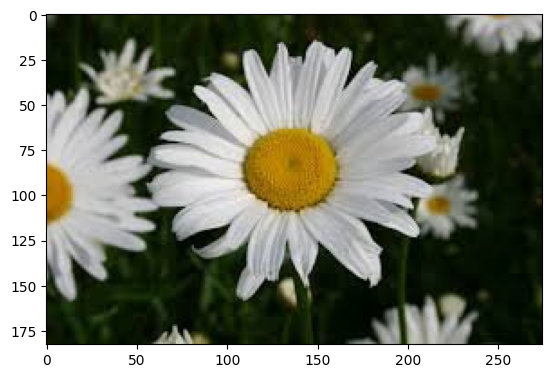

In [30]:
import matplotlib.pyplot as plt

plt.imshow(raw_image)
plt.show()

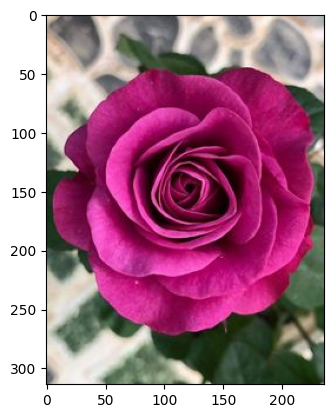

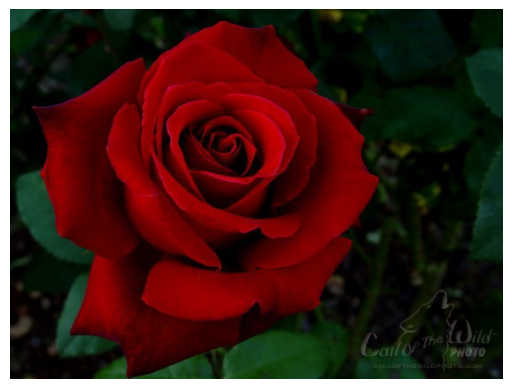

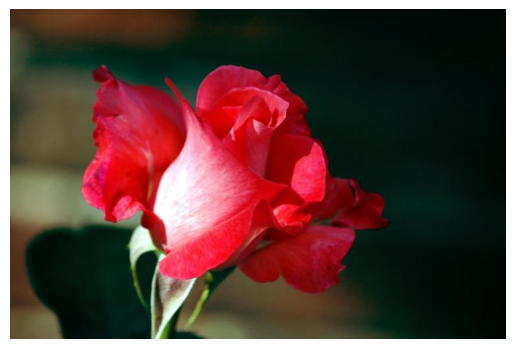

In [31]:
question = 'Answer with organized answers: What type of rose is in the picture? Mention some of its characteristics and how to take care of it ?'

query_image = '/kaggle/input/flowers/flowers/rose/00f6e89a2f949f8165d5222955a5a37d.jpg'
raw_image = Image.open(query_image)

doc = collection_text.query(
    query_embeddings=embedding_function(query_image),
    
    n_results=1,
        
)['documents'][0][0]

plt.imshow(raw_image)
plt.show()
imgs = collection_images.query(query_uris=query_image, include=['data'], n_results=3)
for img in imgs['data'][0][1:]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [32]:
doc

'A rose is either a woody perennial flowering plant of the genus Rosa (), in the family Rosaceae (), or the flower it bears. There are over three hundred species and tens of thousands of cultivars. They form a group of plants that can be erect shrubs, climbing, or trailing, with stems that are often armed with sharp prickles. Their flowers vary in size and shape and are usually large and showy, in colours ranging from white through yellows and reds. Most species are native to Asia, with smaller numbers native to Europe, North America, and northwestern Africa. Species, cultivars and hybrids are all widely grown for their beauty and often are fragrant.  Roses have acquired cultural significance in  many societies. Rose plants range in size from compact, miniature roses, to climbers that can reach seven meters in height. Different species hybridize easily, and this has been used in the development of the wide range of garden roses.'

In [33]:
prompt = """<|im_start|>system
A chat between a curious human and an artificial intelligence assistant.
The assistant is an exprt in flowers , and gives helpful, detailed, and polite answers to the human's questions.
The assistant does not hallucinate and pays very close attention to the details.<|im_end|>
<|im_start|>user
<image>
{question} Use the following article as an answer source. Do not write outside its scope unless you find your answer better {article} if you thin your answer is better add it after document.<|im_end|>
<|im_start|>assistant
""".format(question='question', article=doc)

In [34]:
# prompt = """<|im_start|>system
# A chat between a curious human and an artificial intelligence assistant.
# The assistant is an exprt in flowers , and gives helpful, detailed, and polite answers to the human's questions.
# The assistant does not hallucinate and pays very close attention to the details.<|im_end|>
# <|im_start|>user
# <image>
# Describe the image.<|im_end|>
# <|im_start|>assistant
# """

In [35]:
inputs = processor(prompt, raw_image, model, return_tensors='pt')

inputs['input_ids'] = inputs['input_ids'].to(model.device)
inputs['attention_mask'] = inputs['attention_mask'].to(model.device)

In [36]:
from transformers import TextStreamer

streamer = TextStreamer(tokenizer)

In [37]:
%%time
output = model.generate(**inputs, max_new_tokens=300, do_sample=True, top_p=0.5, temperature=0.2, eos_token_id=tokenizer.eos_token_id, streamer=streamer)

Setting `pad_token_id` to `eos_token_id`:50295 for open-end generation.
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<|im_start|>system
A chat between a curious human and an artificial intelligence assistant.
The assistant is an exprt in flowers, and gives helpful, detailed, and polite answers to the human's questions.
The assistant does not hallucinate and pays very close attention to the details.<|im_end|>
<|im_start|>user
<image>
question Use the following article as an answer source. Do not write outside its scope unless you find your answer better A rose is either a woody perennial flowering plant of the genus Rosa (), in the family Rosaceae (), or the flower it bears. There are over three hundred species and tens of thousands of cultivars. They form a group of plants that can be erect shrubs, climbing, or trailing, with stems that are often armed with sharp prickles. Their flowers vary in size and shape and are usually large and showy, in colours ranging from white through yellows and reds. Most species are native to Asia, with smaller numbers native to Europe, North America, and northwestern A

In [38]:
print(tokenizer.decode(output[0]).replace(prompt, "").replace("<|im_end|>", ""))

<|im_start|>system
A chat between a curious human and an artificial intelligence assistant.
The assistant is an exprt in flowers, and gives helpful, detailed, and polite answers to the human's questions.
The assistant does not hallucinate and pays very close attention to the details.
<|im_start|>user
<image>
question Use the following article as an answer source. Do not write outside its scope unless you find your answer better A rose is either a woody perennial flowering plant of the genus Rosa (), in the family Rosaceae (), or the flower it bears. There are over three hundred species and tens of thousands of cultivars. They form a group of plants that can be erect shrubs, climbing, or trailing, with stems that are often armed with sharp prickles. Their flowers vary in size and shape and are usually large and showy, in colours ranging from white through yellows and reds. Most species are native to Asia, with smaller numbers native to Europe, North America, and northwestern Africa. Spe

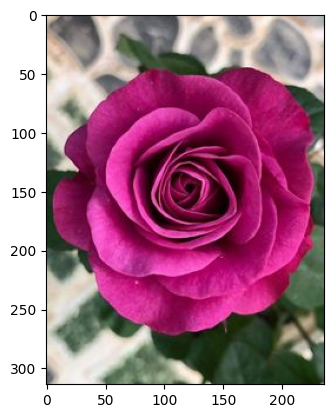

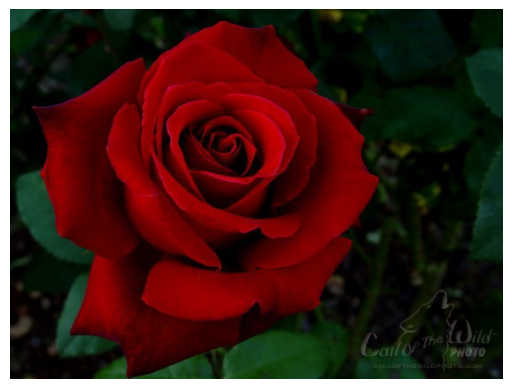

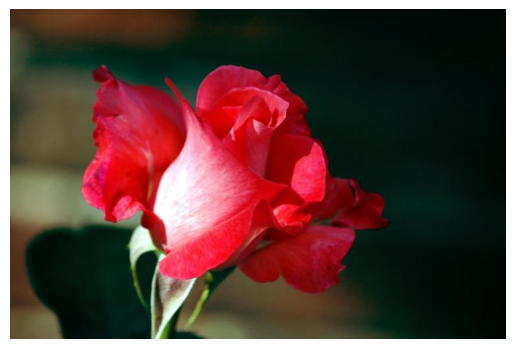

answer is ==> A beautiful dark purple rose is in full bloom against a blurry background. The rose has a velvety texture and is surrounded by green leaves.


In [39]:
plt.imshow(raw_image)
plt.show()
imgs = collection_images.query(query_uris=query_image, include=['data'], n_results=3)
for img in imgs['data'][0][1:]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()
print('answer is ==> '+'A beautiful dark purple rose is in full bloom against a blurry background. The rose has a velvety texture and is surrounded by green leaves.')
